# Project

### 1 Load Packages

In [0]:
# ========================TensorFlow========================
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
# ========================General========================
import os
import io
import sys
import time
import json
import joblib
import pandas as pd
import numpy as np
import requests
import statistics
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# ========================Ploting========================
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# ========================Import Picture========================
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
# ========================Data Preprocessing========================
from sklearn import preprocessing
# Encoding
from sklearn.preprocessing import LabelEncoder
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Data Split
from sklearn.model_selection import train_test_split
# ========================Modeling========================
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree & Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# KMeans
from sklearn.cluster import KMeans
# ========================Evaluation========================
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
# ========================Deep Learning========================
# MLP
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
# ================================================

Using TensorFlow backend.


### 2 Load dataset

In [0]:
# load movie
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    # df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    df['release_year'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.year) if x==x else None)
    df['release_month'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.month) if x==x else None)
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# load movie credits
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [0]:
# Columns that existed in IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [0]:
movies_url = 'https://raw.githubusercontent.com/carrickeane/INFO7390_Data_Sci/master/movie_data.csv'
credits_url = "https://raw.githubusercontent.com/carrickeane/INFO7390_Data_Sci/master/movie_credits.csv"
movies_content = requests.get(movies_url).content
credits_content = requests.get(credits_url).content

movies = load_tmdb_movies(io.StringIO(movies_content.decode('utf-8')))
credits = load_tmdb_credits(io.StringIO(credits_content.decode('utf-8')))
raw_data =convert_to_original_format(movies, credits)

### 3 Data Preprocessing
*   Handling Missing Values
*   Drop Duplication Values
*   Drop Outliers

#### 3.1 Handling Missing Values

In [0]:
raw_data.head(1)

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,release_year,release_month,country,director_name,actor_1_name,actor_2_name,actor_3_name,companies_1,companies_2,companies_3
0,0,Comedy,NaN,3924,blondie,English,Blondie,Blondie and Dagwood are about to celebrate the...,3.005,"[{'id': 5, 'logo_path': '/71BqEFAF4V3qjjMPCpLu...","[{'iso_3166_1': 'US', 'name': 'United States o...",1938-11-30,0,70.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Blondie,6.6,4,1938.0,11.0,United States of America,Frank R. Strayer,Penny Singleton,Arthur Lake,Larry Simms,Columbia Pictures,NaN,NaN


In [0]:
total_missing = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/len(raw_data)).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent], axis=1, keys=['total Missing', 'Percent'])
missing_data.head(10)

,total Missing,Percent
homepage,13456,0.836816
companies_3,11917,0.741107
companies_2,8592,0.534328
tagline,8051,0.500684
companies_1,3062,0.190423
actor_3_name,1096,0.068159
country,1051,0.065361
actor_2_name,887,0.055162
director_name,738,0.045896
language,604,0.037562


In [0]:
# drop homepage & tagline
raw_data.drop(['homepage','tagline'], axis=1, inplace=True)

#### 3.2 Drop Duplication Values and Unseen Features

In [0]:
# Drop Duplication Values
drop_duplicates_subset = ('budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title','overview', 'popularity','release_date', 'gross', 'duration','status','movie_title','vote_average','num_voted_users')
raw_data.drop_duplicates(subset=drop_duplicates_subset, keep='first', inplace=True)

In [0]:
# Drop features that only know after movie release
raw_data.drop(['num_voted_users', 'gross', 'popularity'], axis=1, inplace=True)

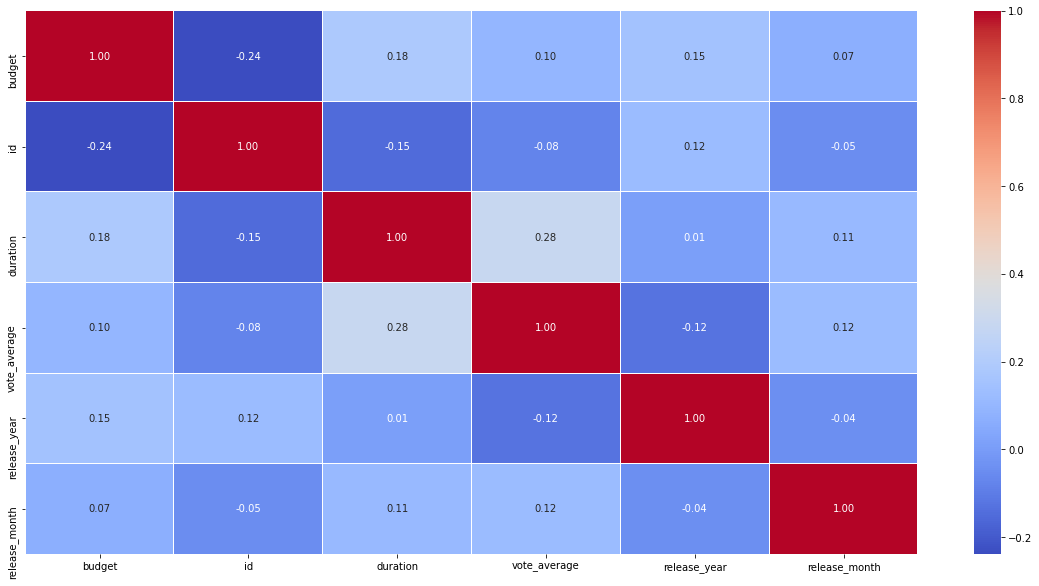

In [0]:
# Correlation matrix between numerical values
plt.figure(figsize = (20,10))
g = sns.heatmap(raw_data[list(raw_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

#### 3.3 Drop Outliers

<Figure size 1080x720 with 0 Axes>

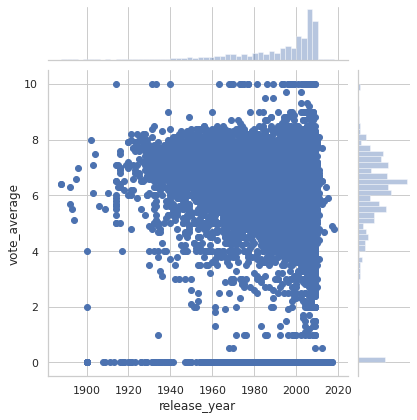

In [0]:
# release_year and vote_average
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.jointplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

In [0]:
# Drop rows in dataset containing 0 and below vote average
before_rows = len(raw_data)
raw_data = raw_data[raw_data['vote_average'] > 0]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 1005 rows;
Current Total rows: 15075


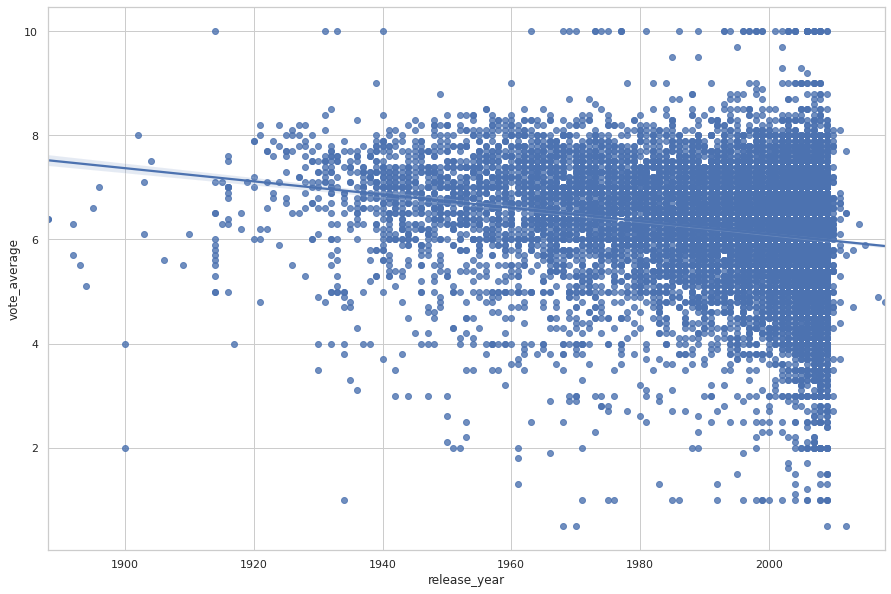

In [0]:
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.regplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

<Figure size 1080x720 with 0 Axes>

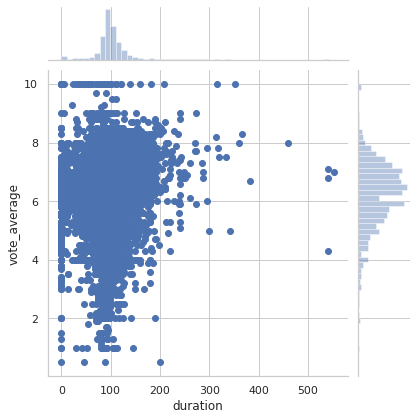

In [0]:
# Duration and vote_average
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.jointplot(x="duration", y="vote_average", data=raw_data)
plt.show()

In [0]:
# Most of directors decide to make 90-120 mins movie, 0-5 duration is not possible
# Drop rows in dataset of which duration <= 5
before_rows = len(raw_data)
raw_data = raw_data[raw_data['duration'] > 5]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 237 rows;
Current Total rows: 14838


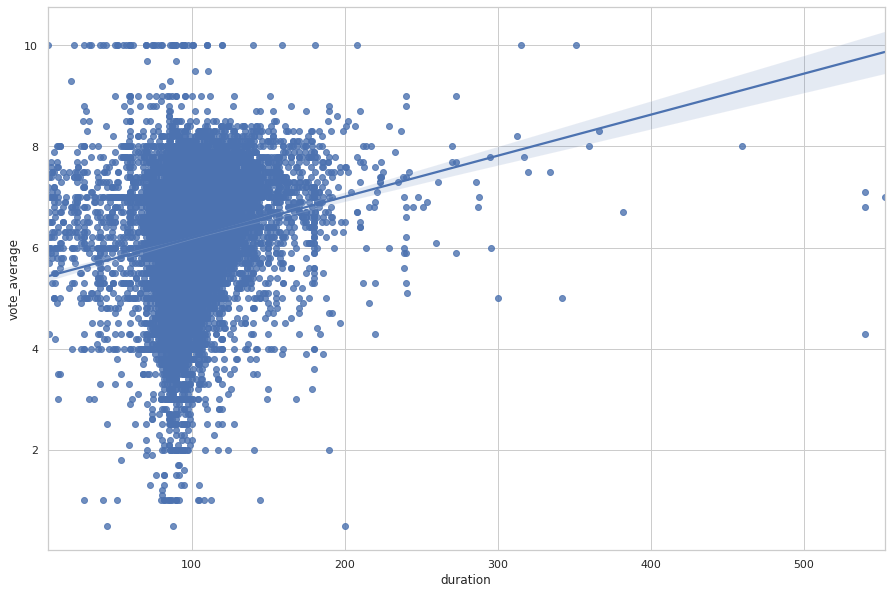

In [0]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.regplot(x="duration", y="vote_average", data=raw_data)
plt.show()

### 4 Data Wrangling: Define a movie is successful or unsuccessful and edit features
*   Define Label
*   Budget
*   Release Year
*   Duration
*   Genres
*   Director
*   Actor
*   Company

#### 4.1 Define Label

In [0]:
# Total columns fot dataset
raw_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'duration', 'spoken_languages', 'status', 'movie_title',
       'vote_average', 'release_year', 'release_month', 'country',
       'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
       'companies_1', 'companies_2', 'companies_3'],
      dtype='object')

In [0]:
raw_data.describe(percentiles=[.10,.25,.5,.75,.9,.99], include=['float','int'])

,budget,id,duration,vote_average,release_year,release_month
count,1.483800e+04,14838.000000,14838.000000,14838.000000,14838.000000,14838.000000
mean,8.095092e+06,13664.260884,101.076156,6.203019,1992.349306,6.547446
std,2.203237e+07,7616.606350,26.936627,1.152474,18.705888,3.621174
min,0.000000e+00,2.000000,6.000000,0.500000,1892.000000,1.000000
10%,0.000000e+00,2160.700000,80.000000,4.700000,1964.000000,1.000000
25%,0.000000e+00,8498.500000,90.000000,5.600000,1984.000000,3.000000
50%,0.000000e+00,13719.500000,98.000000,6.300000,2000.000000,7.000000
75%,3.500000e+06,19844.750000,110.000000,7.000000,2006.000000,10.000000
90%,2.500000e+07,24422.600000,127.000000,7.500000,2008.000000,11.000000
99%,1.050000e+08,26575.630000,183.630000,8.400000,2009.000000,12.000000


In [0]:
# For this kernel, successful movies is a movie which got vote_score more than vote_score mean
raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s >= raw_data['vote_average'].mean() else 0)
raw_data.success.value_counts()

1    7867
0    6971
Name: success, dtype: int64

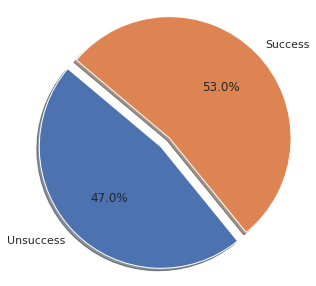

In [0]:
# Data to plot
plt.figure(figsize=(5,5))
labels = ["Unsuccess","Success"]
sizes = raw_data['success'].value_counts(sort=False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

#### 4.2 Budget

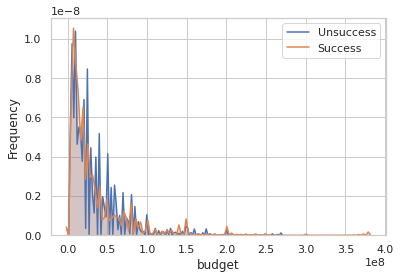

In [0]:
# budget distibution
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

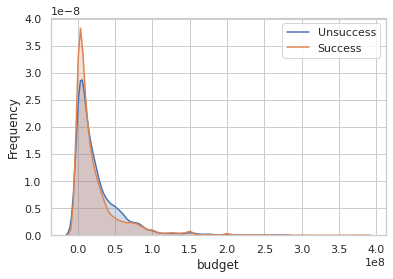

In [0]:
# Non-zero budget distibution
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 0)], shade = True)
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 1)], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

In [0]:
# The Q1,median,Q3,95% of budget of non-zero movies
non_zero_budget_Q1 = raw_data.budget[raw_data.budget>0].quantile(0.25)
non_zero_budget_median = raw_data.budget[raw_data.budget>0].quantile(0.5)
non_zero_budget_Q3 = raw_data.budget[raw_data.budget>0].quantile(0.75)
non_zero_budget_95 = raw_data.budget[raw_data.budget>0].quantile(0.95)

In [0]:
# Create new feature of budget 
raw_data['VeryLowBudget'] = raw_data['budget'].map(lambda s: 1 if s < non_zero_budget_Q1 else 0)
raw_data['LowBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q1 <= s < non_zero_budget_median else 0)
raw_data['MedBudget'] = raw_data['budget'].map(lambda s: 1 if  non_zero_budget_median <= s < non_zero_budget_Q3 else 0)
raw_data['HighBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q3 <= s < non_zero_budget_95 else 0)
raw_data['VeryHighBudget'] = raw_data['budget'].map(lambda s: 1 if s >= non_zero_budget_95 else 0)

#### 4.3 Release Year

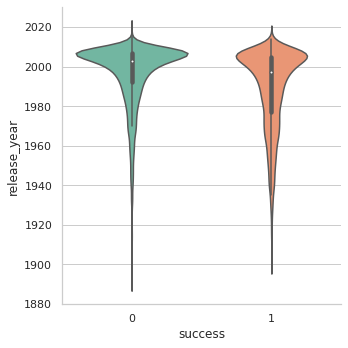

In [0]:
# Release Year Distribution
g = sns.factorplot(y="release_year",x="success",data=raw_data,kind="violin", palette = "Set2")

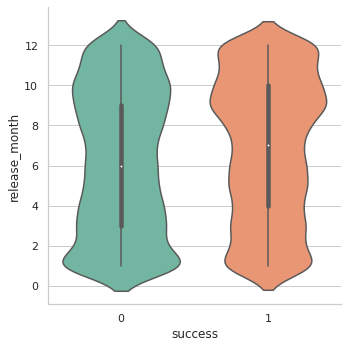

In [0]:
# Release Month Distribution
g = sns.factorplot(y="release_month",x="success",data=raw_data,kind="violin", palette = "Set2")

#### 4.4 Duration

In [0]:
before = len(raw_data)
raw_data = raw_data[np.isfinite(raw_data['duration'])]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before-len(raw_data), len(raw_data)))

Delete 0 rows;
Current Total rows: 14838


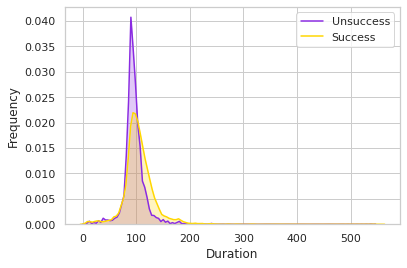

In [0]:
# duration distibution
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

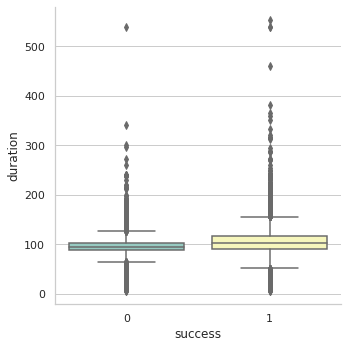

In [0]:
# duration distibution by success
g = sns.factorplot(x="success", y = "duration",data = raw_data, kind="box", palette = "Set3")

In [0]:
'''
Based on common sence
duration <90          => Short Movie
90 <= duration < 120  => Normal Movie
120 <= duration       => Long Movie
'''
raw_data['ShortMovie'] = raw_data['duration'].map(lambda s: 1 if s < 90 else 0)
raw_data['NormalMovie'] = raw_data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
raw_data['LongMovie'] = raw_data['duration'].map(lambda s: 1 if s >= 120 else 0)

#### 4.5 Genres
Since a movie may have multiple genres, we will use one-hot encoding to transform the column of Genres

In [0]:
raw_data.genres.head()

0                Comedy
2         Romance|Drama
4                      
6    Drama|Crime|Comedy
7          Drama|Comedy
Name: genres, dtype: object

In [0]:
def Obtain_list_Occurences(data, column):
    # Obtaining list of column
    listOcc = []
    for i in data[column]:
        split_genre = list(map(str, i.split('|')))
        for j in split_genre:
            if j not in listOcc:
                listOcc.append(j)
    return listOcc

In [0]:
genre = []
genre = Obtain_list_Occurences(raw_data, "genres")
# Drop empty string
genre = list(filter(lambda x:len(x)>0, genre))

In [0]:
# Encoding genre
for w in genre:
    raw_data[w] = raw_data['genres'].map(lambda s: 1 if w in str(s) else 0)

In [0]:
raw_data.loc[:,genre].head()

,Comedy,Romance,Drama,Crime,Action,Thriller,Documentary,Adventure,Science Fiction,Animation,Family,Mystery,Music,Horror,Fantasy,War,History,Western,TV Movie
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 4.6 Director

In [0]:
raw_data.director_name.fillna('unknown', inplace=True)

In [0]:
def to_frequency_table(data):
    frequency = {}
    for key in data:
        if key in frequency and key:
            frequency[key] += 1
        else:
            frequency[key] = 1
    return frequency

In [0]:
director_dic = to_frequency_table(raw_data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
director_list=list(filter(lambda x:x[0]!='unknown', director_list))

In [0]:
# Funtion to find top xx in list
def Top(List, top_num):
    Top = list()
    for i in range(0, top_num):
        Top.append(List[i][0])
    return Top

In [0]:
# Encoding Top 50 director
for w in Top(director_list, 50):
    raw_data[w] = raw_data['director_name'].map(lambda s: 1 if w in str(s) else 0)
# Encoding non-Top 50 director in 'other_director' columns
raw_data['other_director'] = raw_data['director_name'].map(lambda x:1 if x not in Top(director_list, 50) else 0)
print("Total movies of top directors: {};\nTotal movies of non-top directors: {};\nTotal movies: {}.".format(raw_data[Top(director_list, 50)].sum().sum(), raw_data.other_director.sum(), len(raw_data)))

Total movies of top directors: 933;
Total movies of non-top directors: 13905;
Total movies: 14838.


#### 4.7 Actor

In [0]:
# Fill none value in 3 actor columns
raw_data.actor_1_name.fillna('unknown',inplace=True)
raw_data.actor_2_name.fillna('unknown',inplace=True)
raw_data.actor_3_name.fillna('unknown',inplace=True)

In [0]:
raw_data[['actor_1_name','actor_2_name','actor_3_name']]

,actor_1_name,actor_2_name,actor_3_name
0,Penny Singleton,Arthur Lake,Larry Simms
2,Jean-Pierre Léaud,Marie-France Pisier,Patrick Auffay
4,Darren Berrecloth,Cameron McCaul,Paul Basagoitia
6,Turo Pajala,Susanna Haavisto,Matti Pellonpää
7,Matti Pellonpää,Kati Outinen,Sakari Kuosmanen
...,...,...,...
16075,Ivan Mykolaichuk,Larisa Kadochnikova,Tatyana Bestayeva
16076,Ge You,Jiang Wen,Xu Qing
16077,Ellen Dorrit Petersen,Regimantas Adomaitis,Aleksandr Bukharov
16078,Richard Gere,Kim Basinger,Jeroen Krabbé


In [0]:
# # Combine 3 columns and sort the occurrence
# raw_data['actors_name'] = raw_data[['actor_1_name','actor_2_name','actor_3_name']].apply(lambda x:'|'.join(x), axis=1)
# actor_occ = []
# actor_occ = Obtain_list_Occurences(raw_data,"actors_name")
# # Drop 'unknown' string
# actor_occ = list(filter(lambda x:x!='unknown', actor_occ))

In [0]:
# actor_dic = to_frequency_table(actor_occ)
# actor_list = list(actor_dic.items())
# actor_list.sort(key=lambda tup:tup[1],reverse=True)
# # drop 'unknown' item
# actor_list=list(filter(lambda x:x[0]!='unknown', actor_list))

In [0]:
# Encoding actor column
# for w in actor_occ:
#     raw_data[w] = raw_data['actors_name'].map(lambda s: 1 if w in str(s) else 0)

#### 4.8 Company

In [0]:
# Fill none value in 3 actor columns
raw_data['companies_1'].fillna('unknown',inplace=True)
raw_data['companies_2'].fillna('unknown',inplace=True)
raw_data['companies_3'].fillna('unknown',inplace=True)

In [0]:
company_dic = to_frequency_table(raw_data['companies_1'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_1=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_2=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_3=list(filter(lambda x:x[0]!='unknown', company_list))

In [0]:
# Combine all company in one list
full_company_list=sorted(company_list_1+company_list_2+company_list_3)
company_dict={}
for a,b in full_company_list:
    if a not in company_dict.keys():
        company_dict[a] = b
    elif a in company_dict.keys():
        company_dict[a] = company_dict.get(a) + b

combined_company_list = list(company_dict.items())
combined_company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
combined_company_list=list(filter(lambda x:x[0]!='unknown', combined_company_list))

In [0]:
total=0
for a,b in combined_company_list:
    total += b

top_index = 0
top_count = 0
for a,b in combined_company_list:
    if b >= 20:
        top_count += b
        top_index += 1
    else:
        break
print(top_index)
print(len(combined_company_list))
print(combined_company_list[top_index])

131
7967
('Alcon Entertainment', 19)


In [0]:
# Create company columns
toplist = Top(combined_company_list, top_index)
for w in toplist:
    raw_data[w] = 0

In [0]:
# Encoding Top company
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_1'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_2'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_3'].map(lambda x: 1 if x in w else 0)

In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14838 entries, 0 to 16079
Columns: 235 entries, budget to The Asylum
dtypes: float64(4), int64(212), object(19)
memory usage: 27.3+ MB


#### 4.9 Drop Columns

In [0]:
raw_data.drop(['budget','genres','id','plot_keywords','language','original_title','overview',
               'production_companies','production_countries','release_date','duration','spoken_languages','status','movie_title','vote_average','country',
               'director_name','actor_1_name','actor_2_name',
               'actor_3_name','companies_1','companies_2','companies_3'], axis=1, inplace=True)

In [0]:
# Check missing value
total = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/raw_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
The Asylum,0,0.0
Peter Hyams,0,0.0
Robert Altman,0,0.0
John Ford,0,0.0
Werner Herzog,0,0.0


### 5 Modeling
*   Split Data
*   K-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   Conclusion Model Performance
*   Model Test

#### 5.1 Split Data

In [0]:
raw_data.head(1)

,release_year,release_month,success,VeryLowBudget,LowBudget,MedBudget,HighBudget,VeryHighBudget,ShortMovie,NormalMovie,LongMovie,Comedy,Romance,Drama,Crime,Action,Thriller,Documentary,Adventure,Science Fiction,Animation,Family,Mystery,Music,Horror,Fantasy,War,History,Western,TV Movie,Woody Allen,Alfred Hitchcock,Clint Eastwood,Steven Spielberg,Martin Scorsese,Russ Meyer,Gerald Thomas,François Truffaut,John Huston,Jan Švankmajer,...,UK Film Council,Westdeutscher Rundfunk,Les Films du Carrosse,Les Productions Artistes Associés,Robert Simonds Productions,Wild Bunch,Yash Raj Films,Bavaria Film,Central Cinema Company Film (CCC),Film4 Productions,France 3 Cinéma,Franchise Pictures,Intermedia Films,Nimbus Film,Showbox,Universal International Pictures,Artisan Entertainment,Bandai Visual,Disney Channel,MTV Films,Mirage Enterprises,Propaganda Films,The Mirisch Corporation,UTV Motion Pictures,IMAX,Jersey Films,2929 Productions,Fidélité Productions,Films A2,New Regency Pictures,Paramount Vantage,40 Acres & A Mule Filmworks,Alliance Atlantis Communications,Goldcrest Films International,HBO Films,Insight Film Studios,Legendary Entertainment,Production I.G,Scott Rudin Productions,The Asylum
0,1938.0,11.0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Split data into train and test set
data = raw_data
y = data['success']
x = data.drop('success',axis=1)

In [0]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,random_state=10, test_size=.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11, test_size=0.25)

In [0]:
print('x_train: {}; y_train: {}.'.format(x_train.shape, y_train.shape))
print('x_valid: {}; y_valid: {}.'.format(x_valid.shape, y_valid.shape))
print('x_test: {}; y_test: {}.'.format(x_test.shape, y_test.shape))

x_train: (8346, 211); y_train: (8346,).
x_valid: (2782, 211); y_valid: (2782,).
x_test: (3710, 211); y_test: (3710,).


#### 5.2 K-Nearest Neighbors

In [0]:
knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=60, p=2,
                     weights='uniform')

In [0]:
c_knn = cross_val_score(knn, x_train, y_train, cv=10)
c_knn.mean()

0.6315604761699622

### 6 Modeling
*   Feature Importance